

# Imbalanced Learning with Neural Networks (NN)
The goal of this case study is to use various imbalanced learning models to detect whether a transaction is a normal payment or a fraud.


## Content

* [1. Problem Definition](#0)
* [2. Load Packages and Dataset](#1)
    * [2.1. Load Packages](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
    * [3.2. Feature Importance](#2.3)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)    
* [5. Evaluate NN Models](#4) 
    * [5.1. Setup random baseline](#4.1)
    * [5.2. Train/Test Split](#4.2)   
    * [5.3. Scale data](#4.3) 
    * [5.4. Metrics](#4.4)
    * [5.5. Tracking](#4.5)
    * [5.6. Model Functions](#4.6) 
* [6. Model](#5) 
    * [6.1. Baseline](#5.1)
    * [6.2. Random](#5.2)   
    * [6.3. Unbalanced](#5.3) 
    * [6.4. Weighted](#5.4)
    * [6.5. Oversample](#5.5)
    * [6.6. Undersample](#5.6) 
    * [6.7. Balanced batch](#5.7)
    * [6.8. Focal loss](#5.8)   
    * [6.9. Focal loss + oversample](#5.9) 
    * [6.10. Focal loss + balanced batch](#5.10)
* [7. Summary](#6) 
    * [7.1. F1 Score](#6.1)
    * [7.2. Minority recall](#6.2) 


<a id='0'></a>
# 1. Problem Definition

In the classification framework defined for this case study, the response variable takes
a value of 1 in case the given transaction is fraud and 0 otherwise.

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.The task is to get forecast the fraud. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.The features are the result of PCA transformation and aren't intuitive as far as their names are concerned.

The data can be downloaded from: https://www.kaggle.com/mlg-ulb/creditcardfraud


## 1.1. Imbalanced data

- When we're facing a class imbalance accuracy can be misleading when the imbalance is quite high (e.g. >75-80%)
- Gathering additional data for the minority class is a potentially viable solution
    - This technique may be expensive or impractical


- Several approaches can be applied:
    - Adjusting our metrics (e.g. recall, F-Score )
        - F Score variants:
            - F1 -> Cost of False Negative = False Positive
            - F2 -> Cost of False Negative > False Positive
            - F0.5 -> Cost of False Negative < False Positive
    - Balancing the data (e.g. oversampling, undersampling)
    - Changing the model
    - Changing the optimization (e.g. focal imbalance)

<a id='1'></a>
# 2. Load packages & data

<a id='1.1'></a>
## 2.1. Load packages

In [1]:
# #If required install libraries
# !pip install watermark=="2.3.1"
# !pip install shap=="0.41.0"
# !pip install imbalanced-learn=="0.9.0"
# !pip uninstall pycaret

In [2]:
import pandas as pd
from pandas import read_csv, set_option
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import shap
import seaborn as sns
sns.set_theme(style="darkgrid")
import watermark
import sys

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import TruePositives, FalsePositives
from tensorflow.keras.metrics import TrueNegatives, FalseNegatives
from tensorflow.keras.metrics import AUC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from imblearn.keras import BalancedBatchGenerator
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# magics
%matplotlib inline
%load_ext autoreload
%load_ext watermark
%autoreload 2
%watermark --iversions

watermark : 2.3.1
keras     : 2.9.0
pandas    : 1.3.5
numpy     : 1.21.5
sys       : 3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]
tensorflow: 2.9.1
shap      : 0.41.0
matplotlib: 3.5.3
seaborn   : 0.11.2



In [4]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

We load the data in this step.

#### <font color='red'>Note : actual data (144MB) available from https://www.kaggle.com/mlg-ulb/creditcardfraud. You should load the full data in case you want to (instead of sample). </font> 

In [5]:
# load dataset
dataset = read_csv('./input/creditcard.csv')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [6]:
# shape
dataset.shape

(284807, 31)

In [7]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# types
set_option('display.max_rows', 500)
dataset.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

As shown in the results above, the entire data type is float, except Class which is integer, and the variable names aren't intuitive.

In [9]:
# describe data
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.758702e-12,-8.252296e-13,-9.637438e-13,8.316234e-13,1.592013e-13,4.247308e-13,-3.050183e-13,8.692882e-14,-1.179710e-12,...,-3.406538e-13,-5.713357e-13,-9.725290e-13,1.464144e-12,-6.989090e-13,-5.615254e-13,3.332111e-12,-3.518885e-12,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Let us check the number of fraud vs. non-fraud cases in the data set.

In [10]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(dataset.Class.value_counts().rename(index = class_names))

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64


The dataset is unbalanced with most of the transactions being non-fraud.

<a id='2.2'></a>
## 3.2. Data Visualization

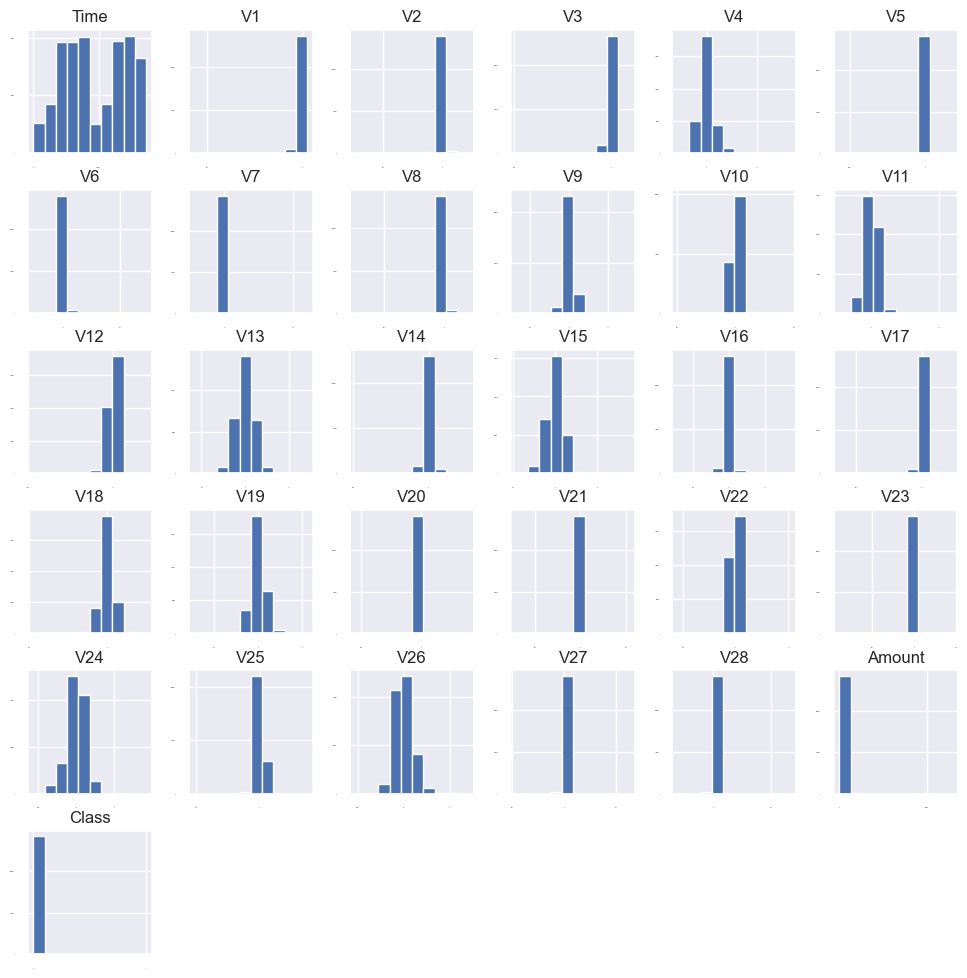

In [11]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

Distribution of most of the variables are highly skewed. However, given the variable names aren't known, we don't get much intuition from the plot.

In [12]:
def plot_feature(df, feature, target):
  fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,3))
  fig.suptitle('the title')
  df.hist(feature, ax=ax1)
  ax1.set_xlabel(feature)
  ax1.set_title(f'Histogram for {feature}')
  df.boxplot(feature, by=target, ax=ax2)
  ax2.set_ylabel(feature)
  ax2.set_title(f'{feature} grouped by {target}')
  plt.show();

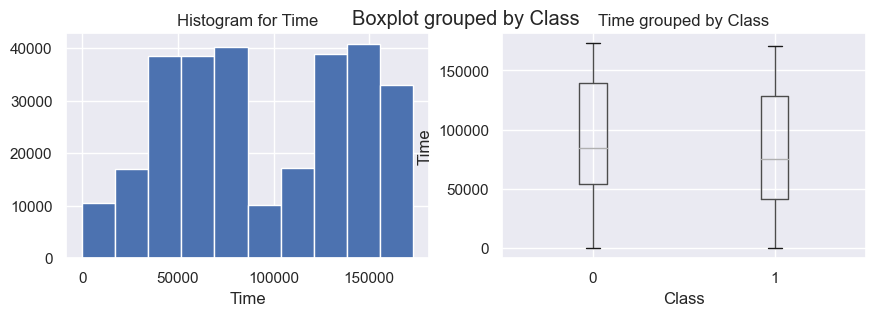

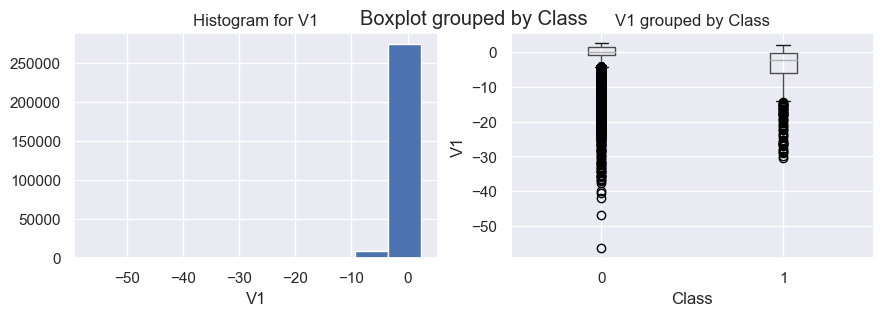

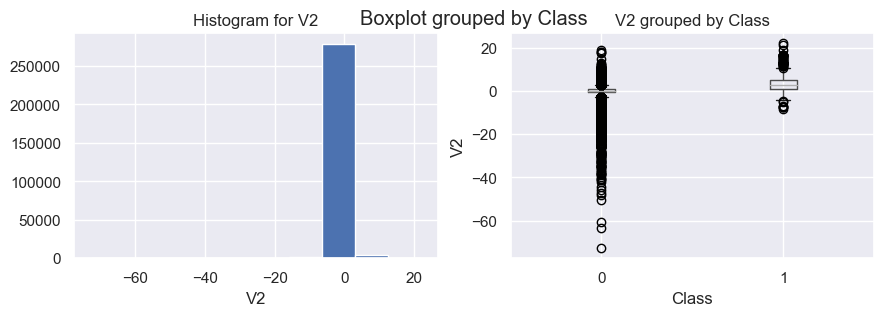

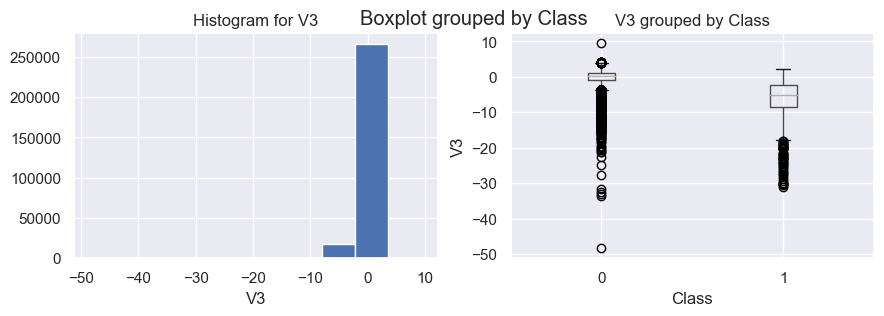

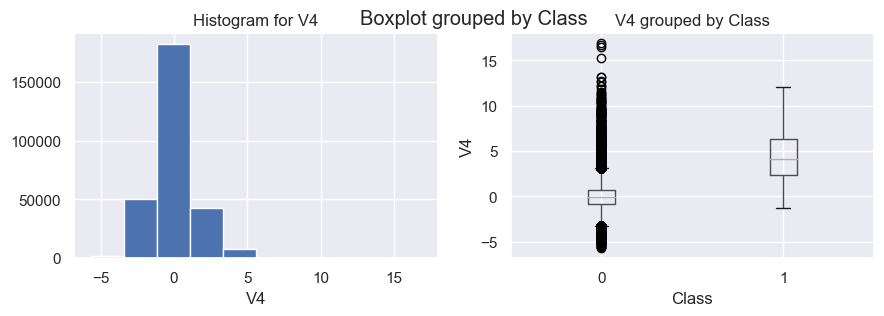

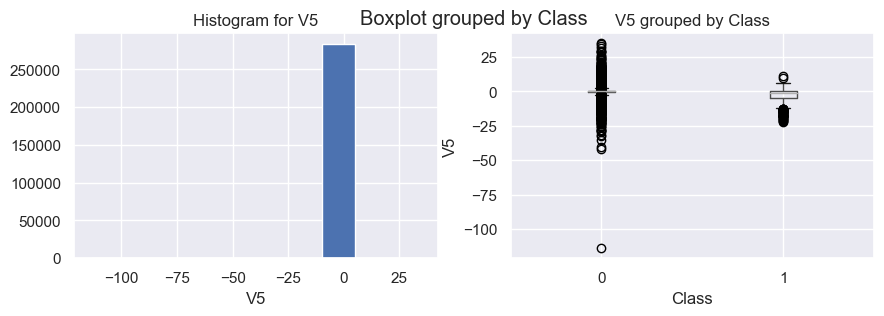

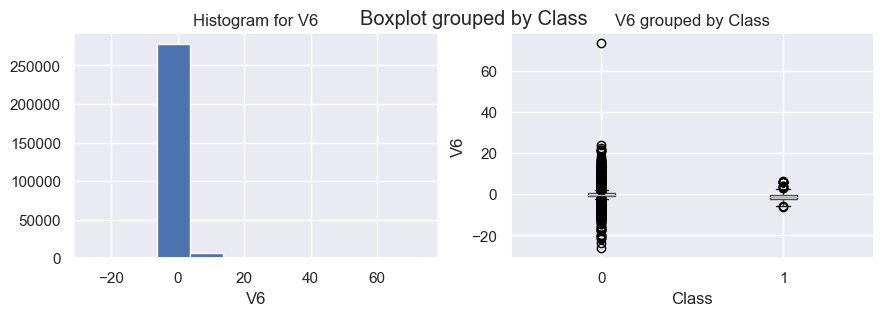

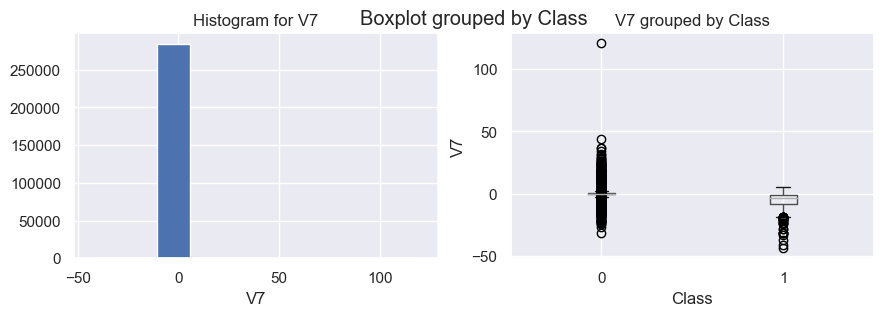

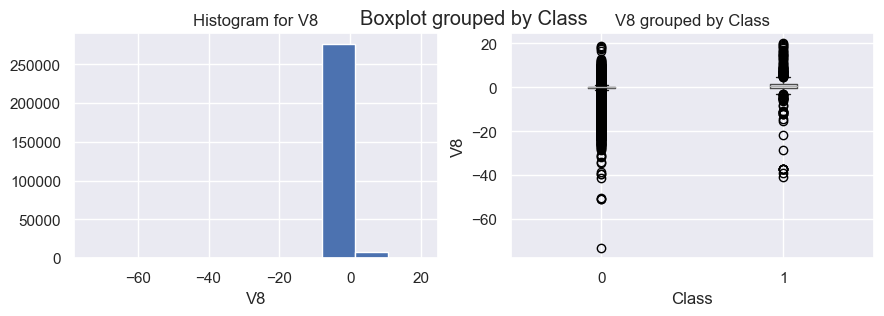

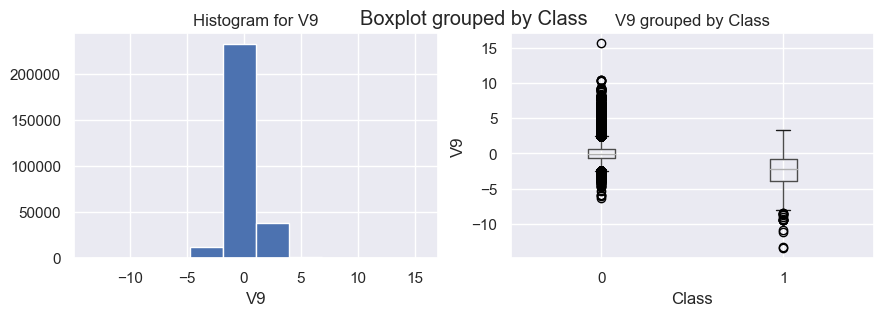

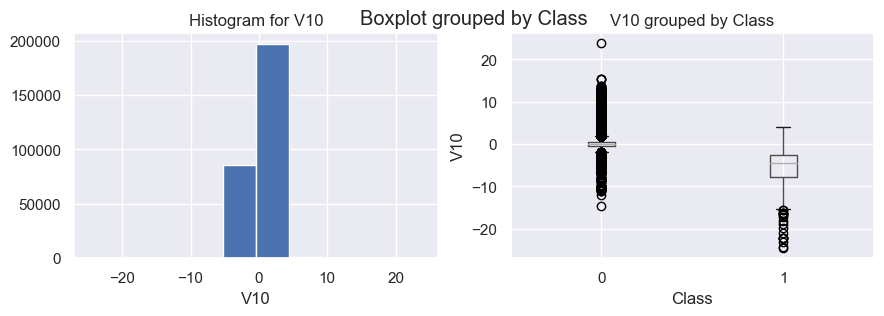

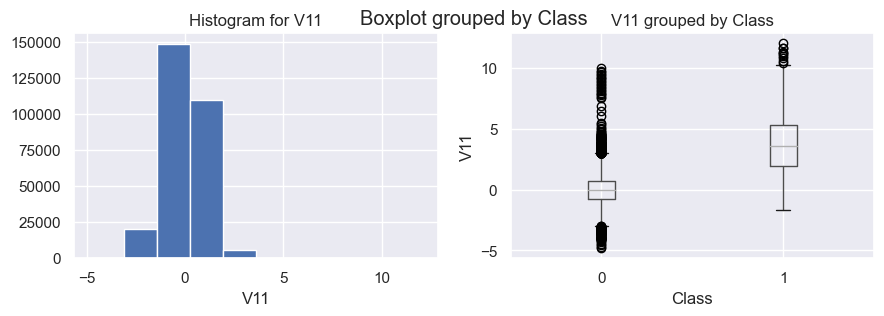

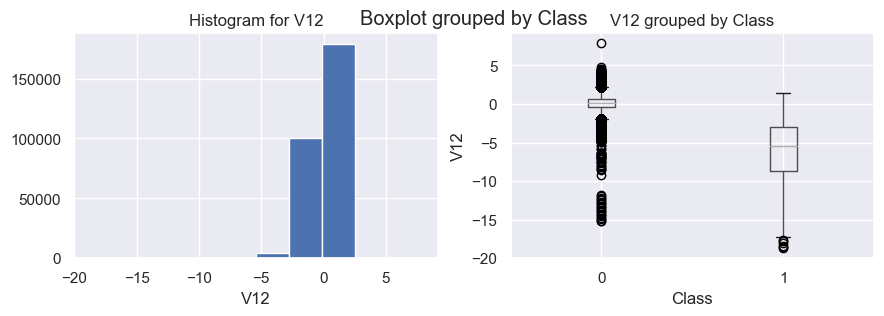

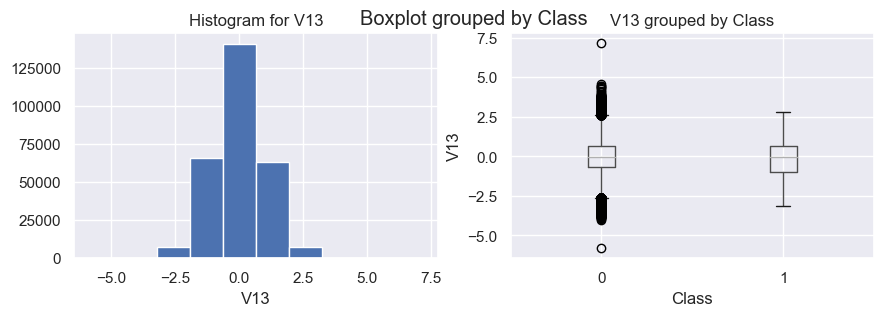

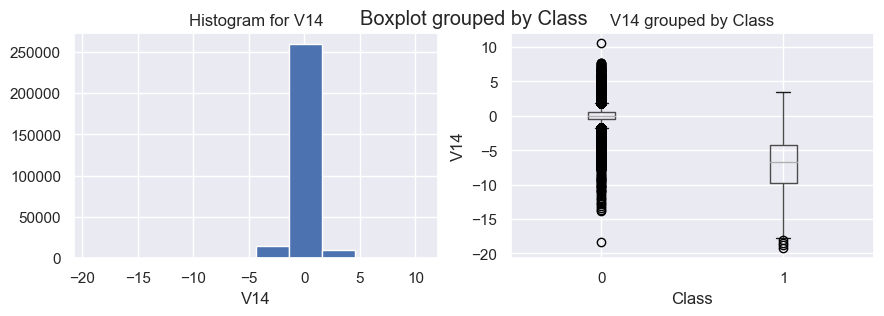

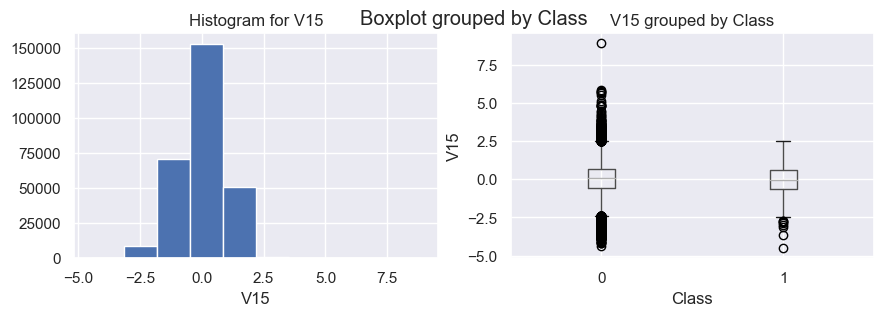

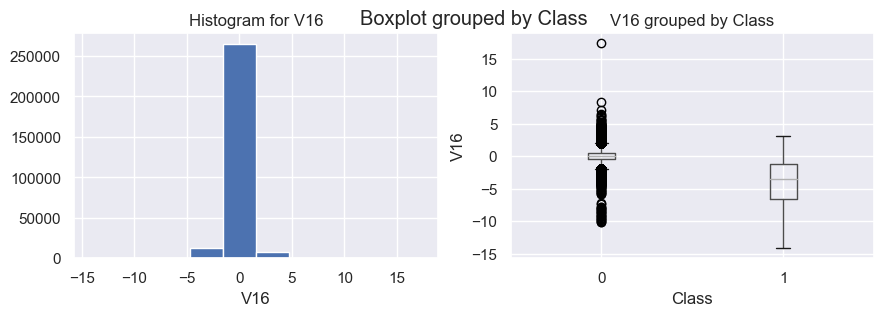

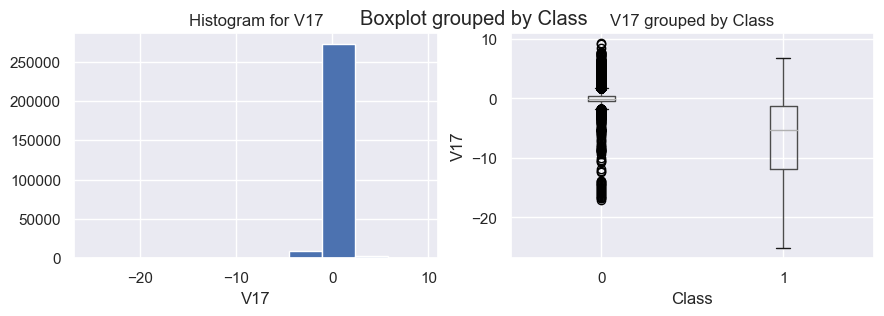

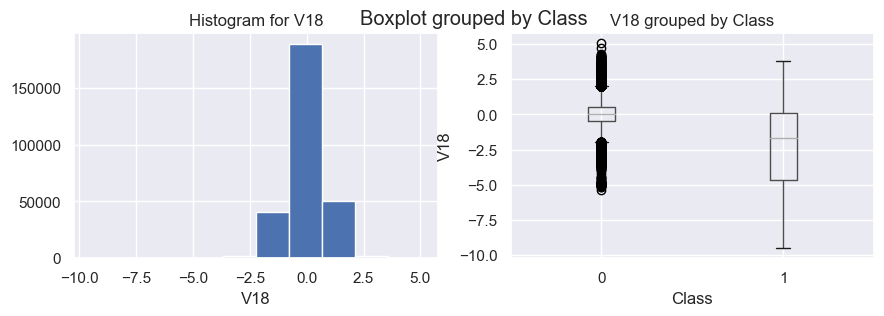

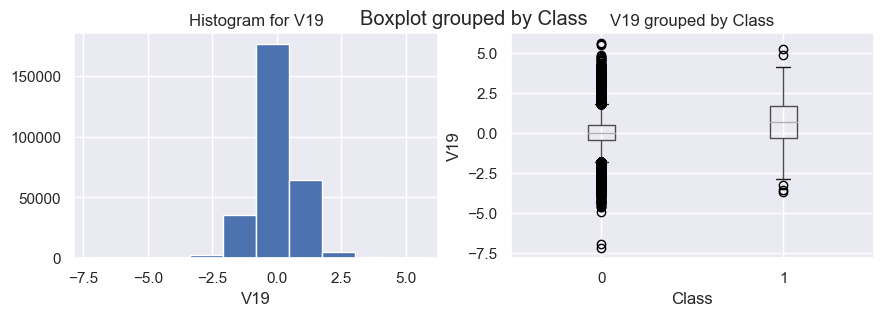

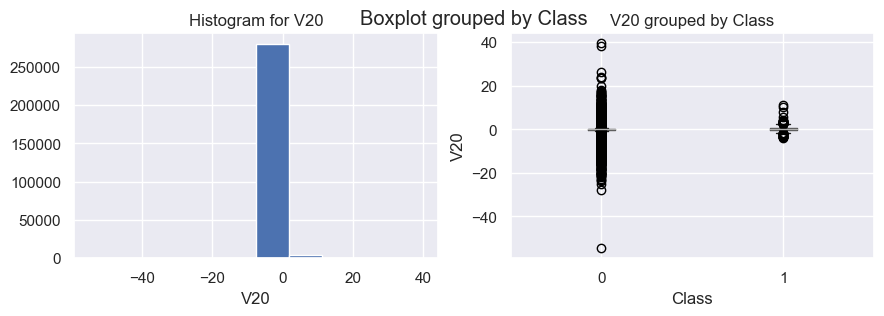

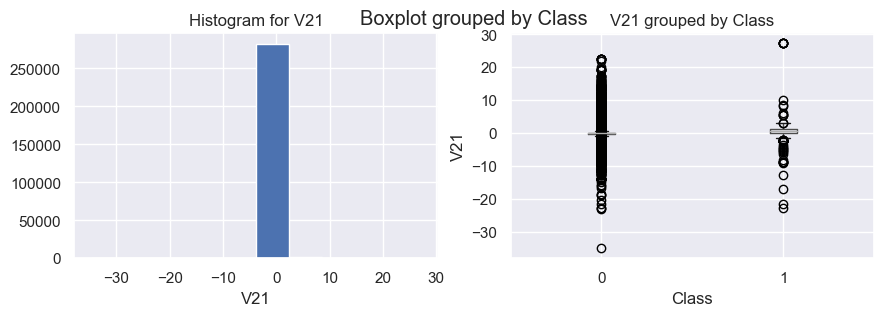

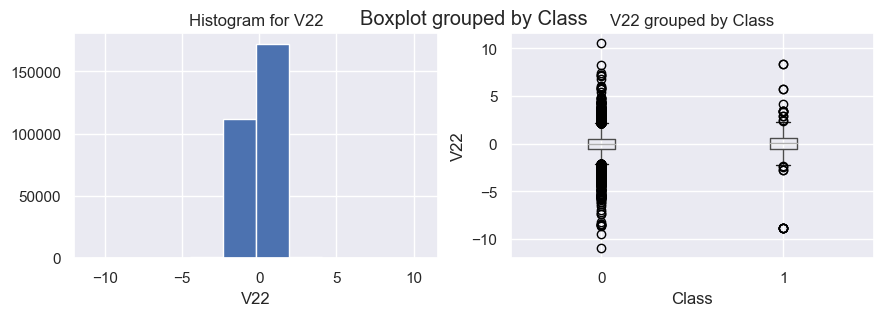

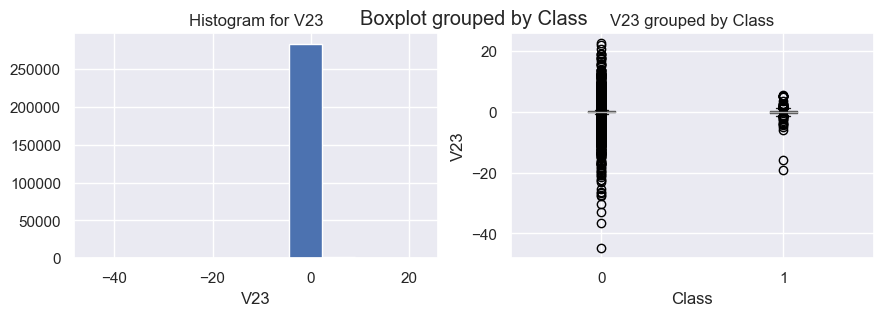

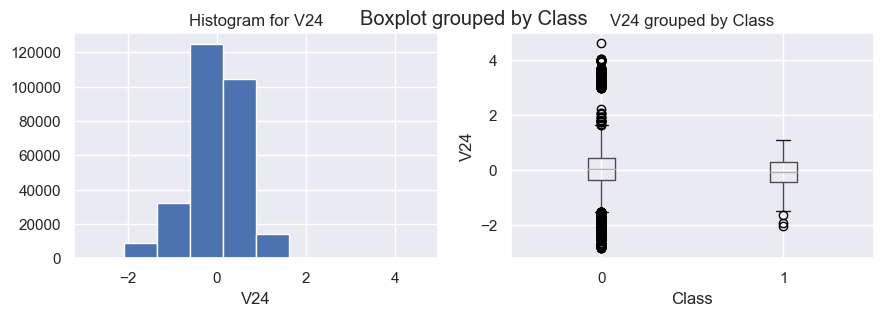

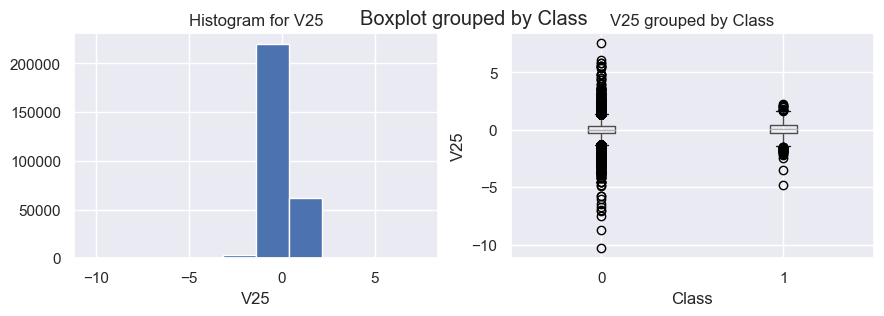

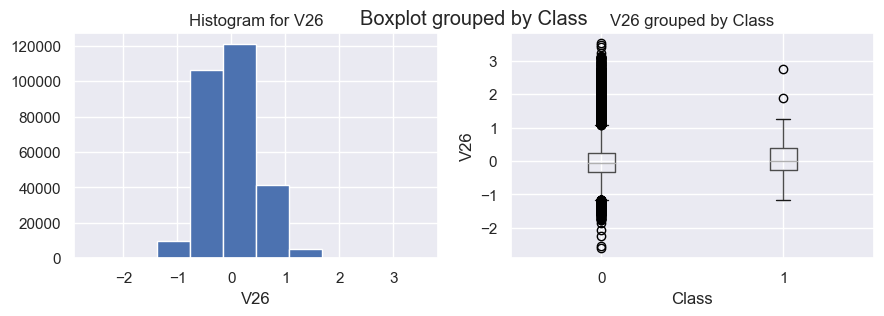

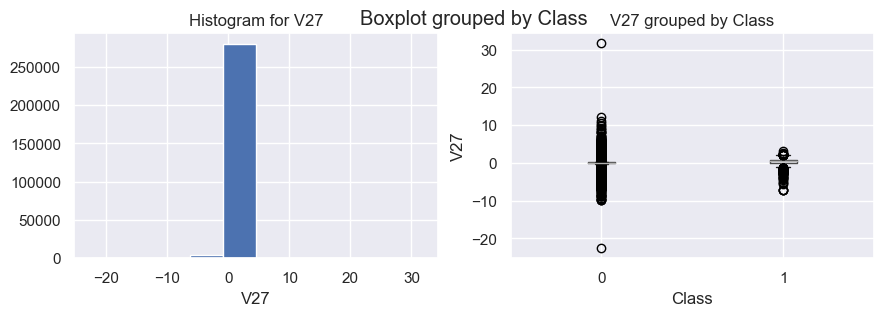

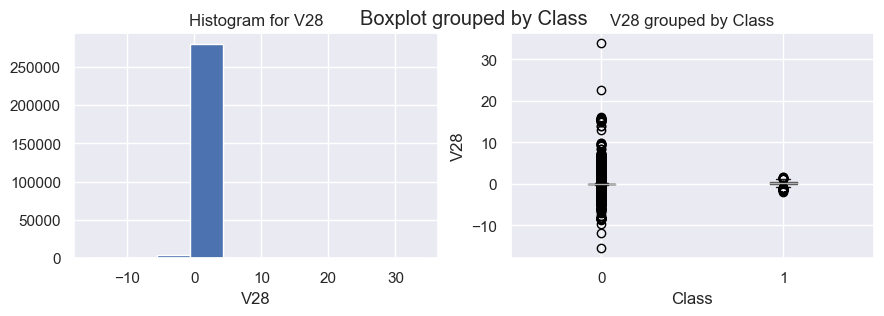

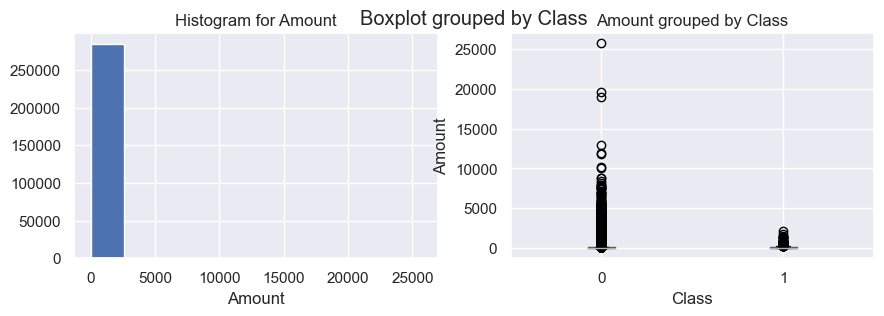

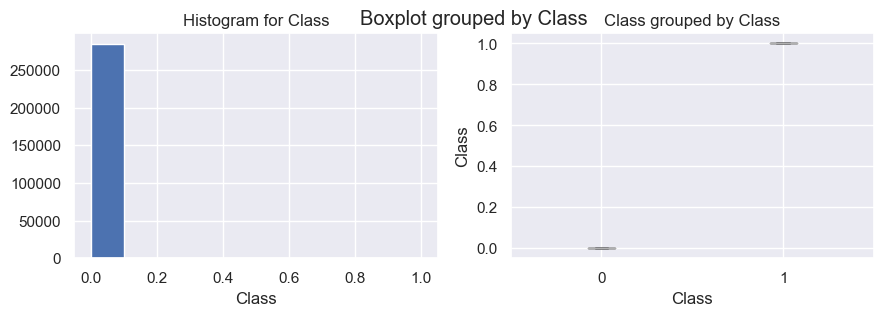

In [13]:
columns = dataset.columns
for col in dataset.columns:
    plot_feature(dataset, col, target='Class')

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning

In [14]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


There is no null in the data, and the data is already in the float format, so there is no need to clean or categorise the data

<a id='4'></a>
# 5. Evaluate NN Models

<a id='4.1'></a>
## 5.1. Random baseline setup

In [15]:
from numpy.random import seed
seed(199)

from tensorflow.random import set_seed
set_seed(199)

<a id='4.2'></a>
## 5.2. Train Test Validation Split and Evaluation Metrics

use f1 as it weights false-negative false-positives equally

In [16]:
# split out validation dataset for the end
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
validation_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)
X_train, X_val, Y_train, Y_val   = train_test_split(X_train, Y_train)

<a id='4.3'></a>
## 5.3 Scale data

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
X_val   = scaler.transform(X_val)

In [18]:
# check scaling in train data
pd.DataFrame([i for i in zip(X.columns, X_train.min(axis=1), X_train.max(axis=1))],
             columns=['Feature', 'Min', 'Max'])

,Feature,Min,Max
0,Time,-1.618445,2.037067
1,V1,-1.955304,2.186582
2,V2,-2.839200,1.465597
3,V3,-1.301437,1.162481
4,V4,-2.093495,1.009484
5,V5,-2.191247,1.299629
6,V6,-3.220421,1.816227
7,V7,-1.894512,2.794563
8,V8,-2.833445,2.595741
9,V9,-2.425239,1.621408


In [19]:
# check scaling in test data
pd.DataFrame([i for i in zip(X.columns, X_test.min(axis=1), X_test.max(axis=1))],
             columns=['Feature', 'Min', 'Max'])

,Feature,Min,Max
0,Time,-0.815090,1.447349
1,V1,-2.193438,1.498361
2,V2,-3.164225,3.009649
3,V3,-1.057045,0.934464
4,V4,-1.260023,2.031214
5,V5,-1.141297,1.123374
6,V6,-2.793751,2.579150
7,V7,-2.530658,1.555174
8,V8,-1.820747,1.656292
9,V9,-1.055784,1.358579


<a id='4.4'></a>
## 5.4 Metrics

In [20]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc')
]

In [21]:
def score_model(y, y_hat):
  cm = confusion_matrix(y, y_hat)
  maj_precision = cm[0][0] / (cm[0][0] + cm[1][0])
  maj_recall    = cm[0][0] / (cm[0][0] + cm[0][1])
  min_precision = cm[1][1] / (cm[1][1] + cm[0][1])
  min_recall    = cm[1][1] / (cm[1][1] + cm[1][0])
  acc = accuracy_score(y, y_hat)
  f1  = f1_score(y, y_hat)
  return cm, acc, (maj_precision, maj_recall), (min_precision, min_recall), f1

In [22]:
def plot_roc(y, probs):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
 
  #Imbalanced ROC Curve
  fpr, tpr, thresholds = roc_curve(y, probs)
  auc_roc = roc_auc_score(y, probs)
  ax1.plot([0, 1], [0, 1], linestyle='--')
  ax1.plot(fpr, tpr, marker='.')
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')
  ax1.set_title('ROC Curve - AUC: %.3f' % auc_roc)

  #Precision Recall Curve
  precision, recall, thresholds = precision_recall_curve(y, probs)
  auc_pre_rec = auc(recall, precision)
  no_skill = sum(y) / len(y)
  ax2.plot([0, 1], [no_skill, no_skill], linestyle='--')
  ax2.plot(recall, precision, marker='.')
  ax2.set_xlabel('Recall')
  ax2.set_ylabel('Precision')
  ax2.set_title('Precision Recall Curve - AUC: %.3f' % auc_pre_rec)

  return auc_roc, auc_pre_rec

<a id='4.5'></a>
## 5.5 Tracking

In [23]:
cols = pd.MultiIndex.from_tuples(zip(['Majority', 'Majority', 'Minority', 'Minority', 'Scoring', 'Scoring'],
                                     ['Precision', 'Recall', 'Precision', 'Recall', 'Accuracy', 'F1']))

results_df = pd.DataFrame(columns=cols)

<a id='4.6'></a>
## 5.6 Model Functions

In [24]:

def construct_model(layers=[64], loss=BinaryCrossentropy(), dropout=0.2):
  model = Sequential()
  model.add(Dense(layers[0], activation='relu', input_shape=(X_train.shape[-1],)))
  
  for layer in layers[1:]:
    model.add(Dense(layer, activation='relu'))
  
  model.add(Dropout(dropout))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=loss,
      metrics=METRICS)

  return model

In [25]:
def plot_history(history):
  plt.figure(figsize=(10,8))
  
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    
    plt.plot(history.epoch, 
             history.history[metric], 
             color='blue', 
             label='Train')
    plt.plot(history.epoch, 
             history.history['val_' + metric],
             color='blue', 
             linestyle="--", 
             label='Val')
    
    plt.xlabel('Epoch')
    plt.ylabel(name)
    
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.2,1])
    else:
      plt.ylim([0,1])
    plt.legend()

<a id='5'></a>
## 6 Model

<a id='5.1'></a>
## 6.1 Baseline

In [26]:
Y_hat_proba = np.repeat(0, len(X_test))
Y_hat = np.where(Y_hat_proba > 0.5, 1, 0)
print(classification_report(Y_test, Y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.00      0.00      0.00       100

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



In [27]:
cm, acc, maj, min, f1 = score_model(Y_test, Y_hat)
results_df.loc['Baseline'] = [*maj, *min, acc, f1]
results_df

Majority         Minority          Scoring     
         Precision Recall Precision Recall  Accuracy   F1
Baseline  0.998244    1.0       NaN    0.0  0.998244  0.0

<a id='5.2'></a>
## 6.2 Random Weights (simplest baseline)

In [28]:
EPOCHS = 100
BATCH_SIZE = 256

early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [29]:
model = construct_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1984      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.predict(X_train[:10])

1/1 [==============================] - 0s 297ms/step


array([[0.57216734],
       [0.6081952 ],
       [0.6284627 ],
       [0.71360785],
       [0.7640947 ],
       [0.61100703],
       [0.7375528 ],
       [0.67112297],
       [0.72180593],
       [0.5355372 ]], dtype=float32)

In [31]:
results = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.0906


In [32]:
Y_hat_proba = model.predict(X_test)
Y_hat = np.where(Y_hat_proba > 0.5, 1, 0)
print(classification_report(Y_test, Y_hat))

1781/1781 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.11      0.20     56862
           1       0.00      0.96      0.00       100

    accuracy                           0.11     56962
   macro avg       0.50      0.54      0.10     56962
weighted avg       1.00      0.11      0.20     56962



In [33]:
cm, acc, maj, min, f1 = score_model(Y_test, Y_hat)
results_df.loc['Random'] = [*maj, *min, acc, f1]
results_df

Majority            Minority          Scoring          
         Precision    Recall Precision Recall  Accuracy        F1
Baseline  0.998244  1.000000       NaN   0.00  0.998244  0.000000
Random    0.999366  0.110847  0.001895   0.96  0.112338  0.003783

<a id='5.3'></a>
## 6.3 Unbalanced

In [34]:
model = construct_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                1984      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [35]:
history_unbalanced = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, Y_val))

Epoch 1/100
668/668 [==============================] - 4s 5ms/step - loss: 0.0599 - tp: 427.0000 - fp: 153281.0000 - tn: 187917.0000 - fn: 141.0000 - accuracy: 0.5511 - precision: 0.0028 - recall: 0.7518 - auc: 0.7916 - val_loss: 0.0064 - val_tp: 76.0000 - val_fp: 10.0000 - val_tn: 56844.0000 - val_fn: 32.0000 - val_accuracy: 0.9993 - val_precision: 0.8837 - val_recall: 0.7037 - val_auc: 0.9136
Epoch 2/100
668/668 [==============================] - 2s 4ms/step - loss: 0.0053 - tp: 192.0000 - fp: 32.0000 - tn: 170567.0000 - fn: 92.0000 - accuracy: 0.9993 - precision: 0.8571 - recall: 0.6761 - auc: 0.9291 - val_loss: 0.0044 - val_tp: 78.0000 - val_fp: 10.0000 - val_tn: 56844.0000 - val_fn: 30.0000 - val_accuracy: 0.9993 - val_precision: 0.8864 - val_recall: 0.7222 - val_auc: 0.9193
Epoch 3/100
668/668 [==============================] - 3s 4ms/step - loss: 0.0037 - tp: 201.0000 - fp: 32.0000 - tn: 170567.0000 - fn: 83.0000 - accuracy: 0.9993 - precision: 0.8627 - recall: 0.7077 - auc: 0.9

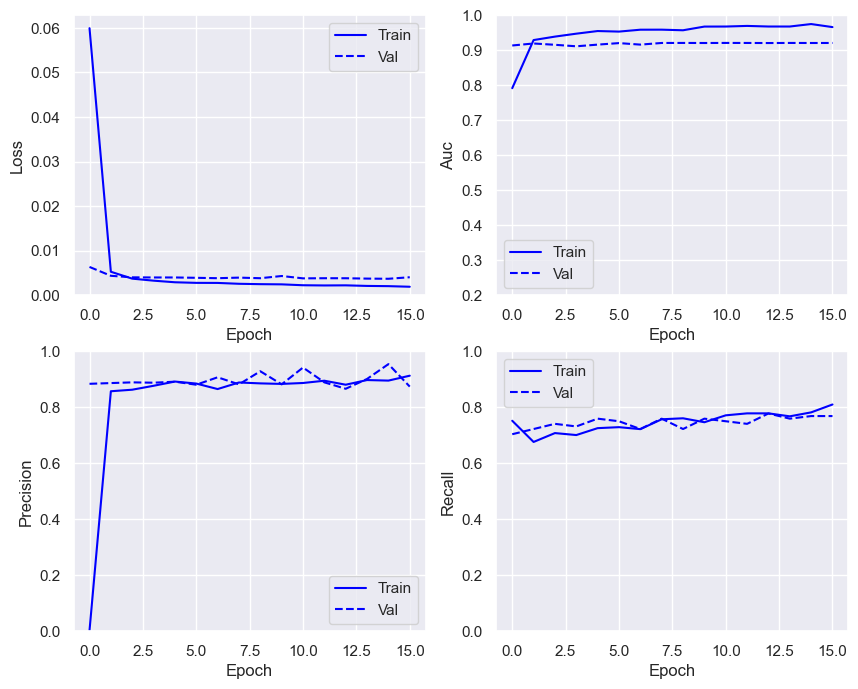

In [36]:
plot_history(history_unbalanced)

In [37]:
Y_hat_proba = model.predict(X_test)
Y_hat = np.where(Y_hat_proba > 0.5, 1, 0)
print(classification_report(Y_test, Y_hat))

1781/1781 [==============================] - 2s 976us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.94      0.78      0.85       100

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [38]:
cm, acc, maj, min, f1 = score_model(Y_test, Y_hat)
results_df.loc['Unbalanced'] = [*maj, *min, acc, f1]
results_df

Majority            Minority          Scoring          
           Precision    Recall Precision Recall  Accuracy        F1
Baseline    0.998244  1.000000       NaN   0.00  0.998244  0.000000
Random      0.999366  0.110847  0.001895   0.96  0.112338  0.003783
Unbalanced  0.999613  0.999912  0.939759   0.78  0.999526  0.852459

<a id='5.4'></a>
## 6.4 Weighted Model

In [39]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
pos = Y_train.sum()
neg = len(Y_train) - pos
tot = len(Y_train)

weight_neg = (1 / neg) * (tot) / 2.0 
weight_pos = (1 / pos) * (tot) / 2.0

class_weight = {0: weight_neg, 1: weight_pos}

print('Weight Negative: {:.2f}'.format(weight_neg))
print('Weight Positive: {:.2f}'.format(weight_pos))

Weight Negative: 0.50
Weight Positive: 300.85


In [40]:
model = construct_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1984      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_weighted = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    class_weight=class_weight,
    validation_data=(X_val, Y_val))

Epoch 1/100
668/668 [==============================] - 4s 5ms/step - loss: 0.3047 - tp: 318.0000 - fp: 4877.0000 - tn: 222576.0000 - fn: 74.0000 - accuracy: 0.9783 - precision: 0.0612 - recall: 0.8112 - auc: 0.9093 - val_loss: 0.1697 - val_tp: 90.0000 - val_fp: 1040.0000 - val_tn: 55814.0000 - val_fn: 18.0000 - val_accuracy: 0.9814 - val_precision: 0.0796 - val_recall: 0.8333 - val_auc: 0.9474
Epoch 2/100
668/668 [==============================] - 3s 5ms/step - loss: 0.1649 - tp: 257.0000 - fp: 3680.0000 - tn: 166919.0000 - fn: 27.0000 - accuracy: 0.9783 - precision: 0.0653 - recall: 0.9049 - auc: 0.9766 - val_loss: 0.1358 - val_tp: 94.0000 - val_fp: 1360.0000 - val_tn: 55494.0000 - val_fn: 14.0000 - val_accuracy: 0.9759 - val_precision: 0.0646 - val_recall: 0.8704 - val_auc: 0.9592
Epoch 3/100
668/668 [==============================] - 3s 5ms/step - loss: 0.1330 - tp: 265.0000 - fp: 4139.0000 - tn: 166460.0000 - fn: 19.0000 - accuracy: 0.9757 - precision: 0.0602 - recall: 0.9331 - auc

Epoch 22/100
668/668 [==============================] - 3s 4ms/step - loss: 0.0402 - tp: 282.0000 - fp: 2466.0000 - tn: 168133.0000 - fn: 2.0000 - accuracy: 0.9856 - precision: 0.1026 - recall: 0.9930 - auc: 0.9989 - val_loss: 0.0372 - val_tp: 93.0000 - val_fp: 600.0000 - val_tn: 56254.0000 - val_fn: 15.0000 - val_accuracy: 0.9892 - val_precision: 0.1342 - val_recall: 0.8611 - val_auc: 0.9581
Epoch 22: early stopping


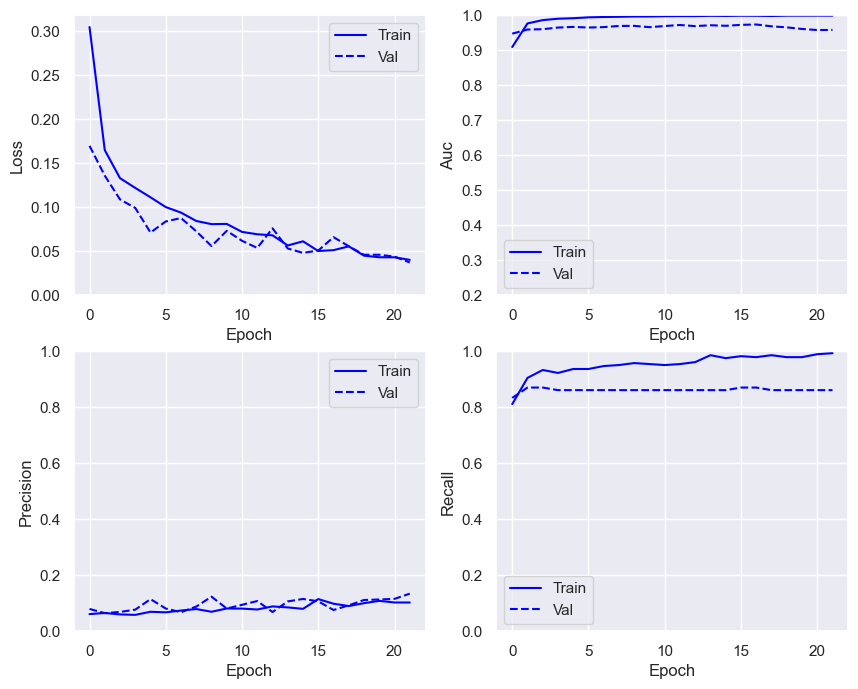

In [42]:
plot_history(history_weighted)

In [43]:
Y_hat_proba = model.predict(X_test)
Y_hat = np.where(Y_hat_proba > 0.5, 1, 0)
print(classification_report(Y_test, Y_hat))

1781/1781 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56862
           1       0.07      0.92      0.13       100

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962



In [44]:
cm, acc, maj, min, f1 = score_model(Y_test, Y_hat)
results_df.loc['Weighted'] = [*maj, *min, acc, f1]
results_df
     

Majority            Minority          Scoring          
           Precision    Recall Precision Recall  Accuracy        F1
Baseline    0.998244  1.000000       NaN   0.00  0.998244  0.000000
Random      0.999366  0.110847  0.001895   0.96  0.112338  0.003783
Unbalanced  0.999613  0.999912  0.939759   0.78  0.999526  0.852459
Weighted    0.999856  0.979266  0.072384   0.92  0.979162  0.134209

<a id='5.5'></a>
## 6.5 Oversample

In [45]:
model = construct_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1984      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [46]:
sampler = RandomOverSampler()
X_over, Y_over = sampler.fit_resample(X_train, Y_train)

In [47]:
history_over_sample = model.fit(
    X_over,
    Y_over,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, Y_val))

Epoch 1/100
1333/1333 [==============================] - 7s 4ms/step - loss: 0.0881 - tp: 163987.0000 - fp: 4886.0000 - tn: 222567.0000 - fn: 6720.0000 - accuracy: 0.9709 - precision: 0.9711 - recall: 0.9606 - auc: 0.9965 - val_loss: 0.0343 - val_tp: 92.0000 - val_fp: 467.0000 - val_tn: 56387.0000 - val_fn: 16.0000 - val_accuracy: 0.9915 - val_precision: 0.1646 - val_recall: 0.8519 - val_auc: 0.9622
Epoch 2/100
1333/1333 [==============================] - 5s 4ms/step - loss: 0.0251 - tp: 169911.0000 - fp: 1367.0000 - tn: 169232.0000 - fn: 688.0000 - accuracy: 0.9940 - precision: 0.9920 - recall: 0.9960 - auc: 0.9996 - val_loss: 0.0207 - val_tp: 92.0000 - val_fp: 294.0000 - val_tn: 56560.0000 - val_fn: 16.0000 - val_accuracy: 0.9946 - val_precision: 0.2383 - val_recall: 0.8519 - val_auc: 0.9413
Epoch 3/100
1333/1333 [==============================] - 6s 4ms/step - loss: 0.0147 - tp: 170512.0000 - fp: 904.0000 - tn: 169695.0000 - fn: 87.0000 - accuracy: 0.9971 - precision: 0.9947 - recal

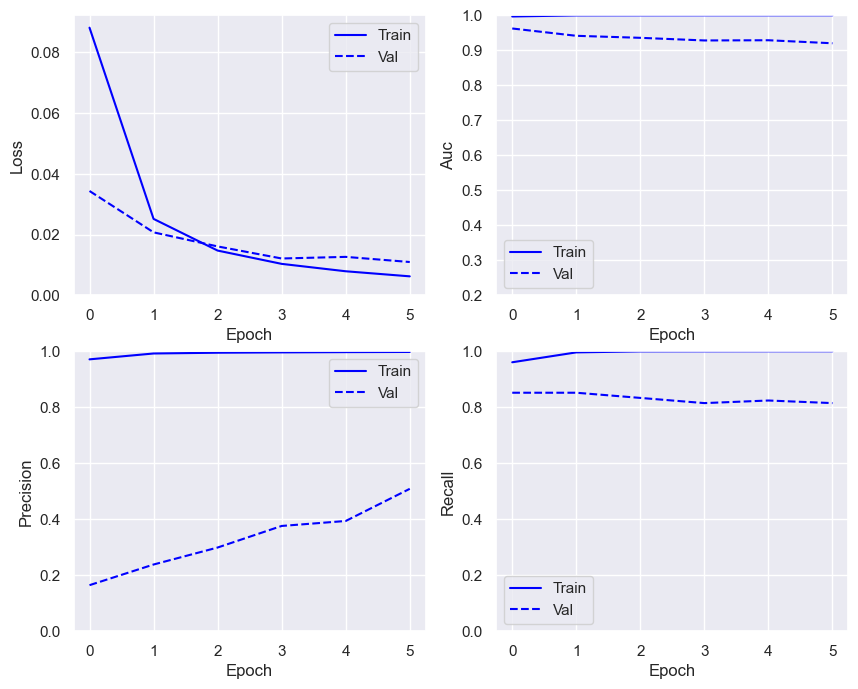

In [48]:
plot_history(history_over_sample)

In [49]:
Y_hat_proba = model.predict(X_test)
Y_hat = np.where(Y_hat_proba > 0.5, 1, 0)
print(classification_report(Y_test, Y_hat))

1781/1781 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56862
           1       0.16      0.91      0.27       100

    accuracy                           0.99     56962
   macro avg       0.58      0.95      0.63     56962
weighted avg       1.00      0.99      0.99     56962



In [50]:
cm, acc, maj, min, f1 = score_model(Y_test, Y_hat)
results_df.loc['Over Sample'] = [*maj, *min, acc, f1]
results_df

Majority            Minority          Scoring          
            Precision    Recall Precision Recall  Accuracy        F1
Baseline     0.998244  1.000000       NaN   0.00  0.998244  0.000000
Random       0.999366  0.110847  0.001895   0.96  0.112338  0.003783
Unbalanced   0.999613  0.999912  0.939759   0.78  0.999526  0.852459
Weighted     0.999856  0.979266  0.072384   0.92  0.979162  0.134209
Over Sample  0.999840  0.991506  0.158537   0.91  0.991363  0.270030

<a id='5.6'></a>
## 6.6 Undersample

In [51]:
model = construct_model()
model.summary()     

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                1984      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [52]:
sampler = RandomUnderSampler()
X_under, Y_under = sampler.fit_resample(X_train, Y_train)

In [53]:
history_under_sample = model.fit(
    X_under,
    Y_under,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, Y_val))

Epoch 1/100
3/3 [==============================] - 2s 460ms/step - loss: 2.6917 - tp: 137.0000 - fp: 164.0000 - tn: 56974.0000 - fn: 255.0000 - accuracy: 0.9927 - precision: 0.4551 - recall: 0.3495 - auc: 0.8586 - val_loss: 0.5550 - val_tp: 27.0000 - val_fp: 14211.0000 - val_tn: 42643.0000 - val_fn: 81.0000 - val_accuracy: 0.7491 - val_precision: 0.0019 - val_recall: 0.2500 - val_auc: 0.3010
Epoch 2/100
3/3 [==============================] - 1s 254ms/step - loss: 1.9915 - tp: 54.0000 - fp: 89.0000 - tn: 195.0000 - fn: 230.0000 - accuracy: 0.4384 - precision: 0.3776 - recall: 0.1901 - auc: 0.2671 - val_loss: 0.5661 - val_tp: 32.0000 - val_fp: 15346.0000 - val_tn: 41508.0000 - val_fn: 76.0000 - val_accuracy: 0.7293 - val_precision: 0.0021 - val_recall: 0.2963 - val_auc: 0.3531
Epoch 3/100
3/3 [==============================] - 0s 206ms/step - loss: 1.6339 - tp: 77.0000 - fp: 86.0000 - tn: 198.0000 - fn: 207.0000 - accuracy: 0.4842 - precision: 0.4724 - recall: 0.2711 - auc: 0.3532 - val_

Epoch 22/100
3/3 [==============================] - 0s 239ms/step - loss: 0.2927 - tp: 264.0000 - fp: 27.0000 - tn: 257.0000 - fn: 20.0000 - accuracy: 0.9173 - precision: 0.9072 - recall: 0.9296 - auc: 0.9570 - val_loss: 0.4147 - val_tp: 94.0000 - val_fp: 3773.0000 - val_tn: 53081.0000 - val_fn: 14.0000 - val_accuracy: 0.9335 - val_precision: 0.0243 - val_recall: 0.8704 - val_auc: 0.9369
Epoch 23/100
3/3 [==============================] - 1s 247ms/step - loss: 0.2826 - tp: 261.0000 - fp: 26.0000 - tn: 258.0000 - fn: 23.0000 - accuracy: 0.9137 - precision: 0.9094 - recall: 0.9190 - auc: 0.9616 - val_loss: 0.4028 - val_tp: 93.0000 - val_fp: 3357.0000 - val_tn: 53497.0000 - val_fn: 15.0000 - val_accuracy: 0.9408 - val_precision: 0.0270 - val_recall: 0.8611 - val_auc: 0.9376
Epoch 24/100
3/3 [==============================] - 1s 255ms/step - loss: 0.2927 - tp: 260.0000 - fp: 21.0000 - tn: 263.0000 - fn: 24.0000 - accuracy: 0.9208 - precision: 0.9253 - recall: 0.9155 - auc: 0.9586 - val_los

Epoch 43/100
3/3 [==============================] - 0s 230ms/step - loss: 0.1982 - tp: 255.0000 - fp: 2.0000 - tn: 282.0000 - fn: 29.0000 - accuracy: 0.9454 - precision: 0.9922 - recall: 0.8979 - auc: 0.9794 - val_loss: 0.2500 - val_tp: 91.0000 - val_fp: 1233.0000 - val_tn: 55621.0000 - val_fn: 17.0000 - val_accuracy: 0.9781 - val_precision: 0.0687 - val_recall: 0.8426 - val_auc: 0.9519
Epoch 44/100
3/3 [==============================] - 0s 225ms/step - loss: 0.2110 - tp: 259.0000 - fp: 8.0000 - tn: 276.0000 - fn: 25.0000 - accuracy: 0.9419 - precision: 0.9700 - recall: 0.9120 - auc: 0.9739 - val_loss: 0.2459 - val_tp: 91.0000 - val_fp: 1234.0000 - val_tn: 55620.0000 - val_fn: 17.0000 - val_accuracy: 0.9780 - val_precision: 0.0687 - val_recall: 0.8426 - val_auc: 0.9528
Epoch 45/100
3/3 [==============================] - 0s 247ms/step - loss: 0.1882 - tp: 257.0000 - fp: 5.0000 - tn: 279.0000 - fn: 27.0000 - accuracy: 0.9437 - precision: 0.9809 - recall: 0.9049 - auc: 0.9840 - val_loss: 

3/3 [==============================] - 0s 166ms/step - loss: 0.1601 - tp: 261.0000 - fp: 3.0000 - tn: 281.0000 - fn: 23.0000 - accuracy: 0.9542 - precision: 0.9886 - recall: 0.9190 - auc: 0.9855 - val_loss: 0.1843 - val_tp: 91.0000 - val_fp: 1123.0000 - val_tn: 55731.0000 - val_fn: 17.0000 - val_accuracy: 0.9800 - val_precision: 0.0750 - val_recall: 0.8426 - val_auc: 0.9595
Epoch 65/100
3/3 [==============================] - 0s 179ms/step - loss: 0.1626 - tp: 258.0000 - fp: 2.0000 - tn: 282.0000 - fn: 26.0000 - accuracy: 0.9507 - precision: 0.9923 - recall: 0.9085 - auc: 0.9844 - val_loss: 0.1822 - val_tp: 91.0000 - val_fp: 1119.0000 - val_tn: 55735.0000 - val_fn: 17.0000 - val_accuracy: 0.9801 - val_precision: 0.0752 - val_recall: 0.8426 - val_auc: 0.9597
Epoch 66/100
3/3 [==============================] - 0s 186ms/step - loss: 0.1529 - tp: 263.0000 - fp: 4.0000 - tn: 280.0000 - fn: 21.0000 - accuracy: 0.9560 - precision: 0.9850 - recall: 0.9261 - auc: 0.9859 - val_loss: 0.1799 - val_

3/3 [==============================] - 1s 252ms/step - loss: 0.1340 - tp: 262.0000 - fp: 3.0000 - tn: 281.0000 - fn: 22.0000 - accuracy: 0.9560 - precision: 0.9887 - recall: 0.9225 - auc: 0.9894 - val_loss: 0.1555 - val_tp: 93.0000 - val_fp: 1228.0000 - val_tn: 55626.0000 - val_fn: 15.0000 - val_accuracy: 0.9782 - val_precision: 0.0704 - val_recall: 0.8611 - val_auc: 0.9644
Epoch 86/100
3/3 [==============================] - 1s 271ms/step - loss: 0.1216 - tp: 263.0000 - fp: 3.0000 - tn: 281.0000 - fn: 21.0000 - accuracy: 0.9577 - precision: 0.9887 - recall: 0.9261 - auc: 0.9925 - val_loss: 0.1545 - val_tp: 93.0000 - val_fp: 1233.0000 - val_tn: 55621.0000 - val_fn: 15.0000 - val_accuracy: 0.9781 - val_precision: 0.0701 - val_recall: 0.8611 - val_auc: 0.9647
Epoch 87/100
3/3 [==============================] - 0s 222ms/step - loss: 0.1234 - tp: 266.0000 - fp: 4.0000 - tn: 280.0000 - fn: 18.0000 - accuracy: 0.9613 - precision: 0.9852 - recall: 0.9366 - auc: 0.9910 - val_loss: 0.1534 - val_

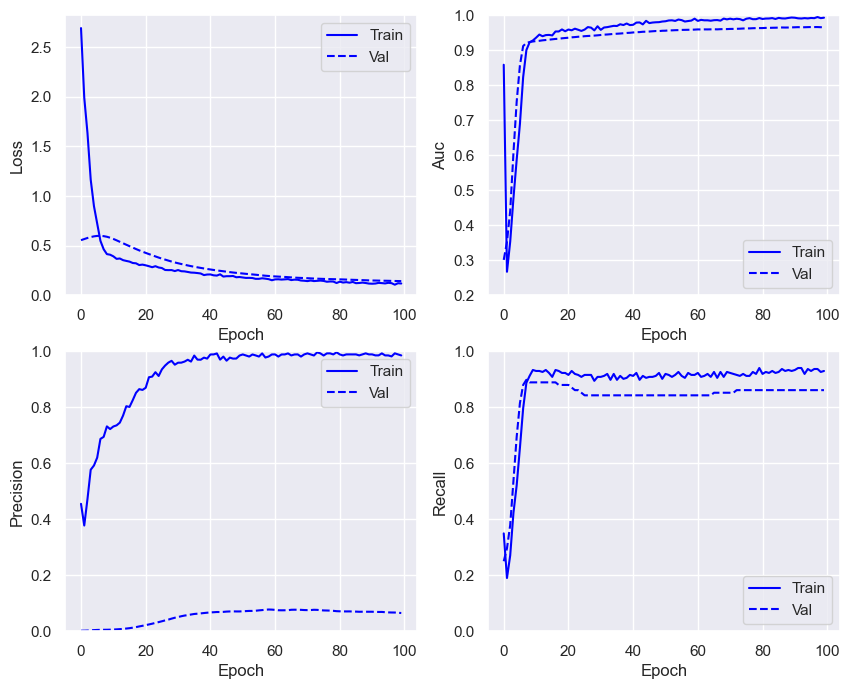

In [54]:
plot_history(history_under_sample)

In [55]:
Y_hat_proba = model.predict(X_test)
Y_hat = np.where(Y_hat_proba > 0.5, 1, 0)
print(classification_report(Y_test, Y_hat))

1781/1781 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56862
           1       0.06      0.91      0.12       100

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [56]:
cm, acc, maj, min, f1 = score_model(Y_test, Y_hat)
results_df.loc['Under Sample'] = [*maj, *min, acc, f1]
results_df

Majority            Minority          Scoring          
             Precision    Recall Precision Recall  Accuracy        F1
Baseline      0.998244  1.000000       NaN   0.00  0.998244  0.000000
Random        0.999366  0.110847  0.001895   0.96  0.112338  0.003783
Unbalanced    0.999613  0.999912  0.939759   0.78  0.999526  0.852459
Weighted      0.999856  0.979266  0.072384   0.92  0.979162  0.134209
Over Sample   0.999840  0.991506  0.158537   0.91  0.991363  0.270030
Under Sample  0.999838  0.976047  0.062629   0.91  0.975931  0.117193

<a id='5.7'></a>
## 6.7 Batch Sample

In [57]:
model = construct_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                1984      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [58]:
training_generator = BalancedBatchGenerator(
    X_train, 
    Y_train.to_numpy(), 
    sampler=RandomOverSampler(), 
    batch_size=32, 
    random_state=42)

In [59]:
history_batch_balanced = model.fit(
    training_generator,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    callbacks = [early_stopping])

Epoch 1/100
10662/10662 [==============================] - 35s 3ms/step - loss: 0.0372 - tp: 168509.0000 - fp: 3078.0000 - tn: 224366.0000 - fn: 2193.0000 - accuracy: 0.9868 - precision: 0.9821 - recall: 0.9872 - auc: 0.9987 - val_loss: 0.0166 - val_tp: 92.0000 - val_fp: 255.0000 - val_tn: 56599.0000 - val_fn: 16.0000 - val_accuracy: 0.9952 - val_precision: 0.2651 - val_recall: 0.8519 - val_auc: 0.9412
Epoch 2/100
10662/10662 [==============================] - 33s 3ms/step - loss: 0.0077 - tp: 170558.0000 - fp: 537.0000 - tn: 170053.0000 - fn: 36.0000 - accuracy: 0.9983 - precision: 0.9969 - recall: 0.9998 - auc: 0.9998 - val_loss: 0.0124 - val_tp: 85.0000 - val_fp: 111.0000 - val_tn: 56743.0000 - val_fn: 23.0000 - val_accuracy: 0.9976 - val_precision: 0.4337 - val_recall: 0.7870 - val_auc: 0.9201
Epoch 3/100
10662/10662 [==============================] - 33s 3ms/step - loss: 0.0051 - tp: 170560.0000 - fp: 342.0000 - tn: 170248.0000 - fn: 34.0000 - accuracy: 0.9989 - precision: 0.9980 

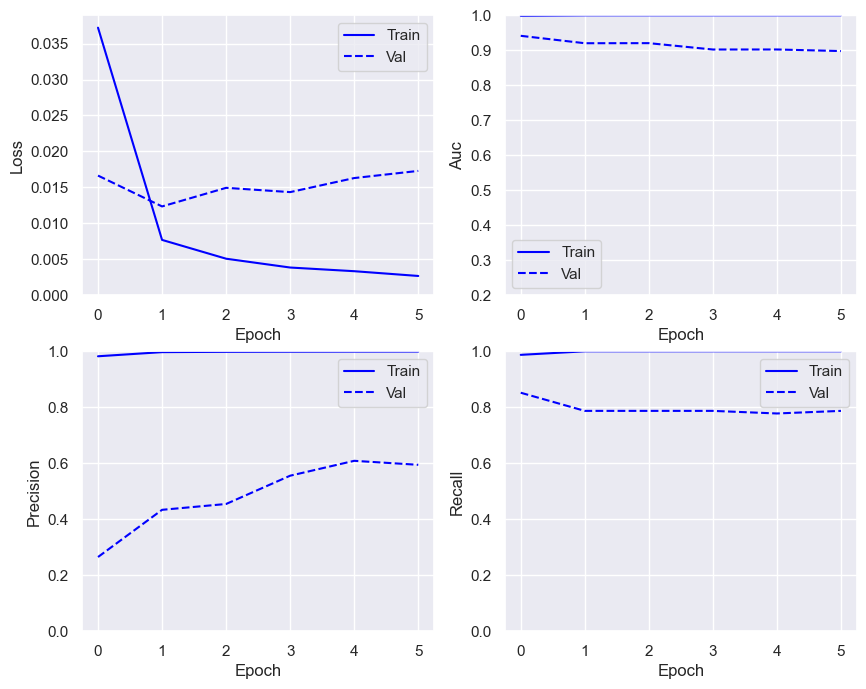

In [60]:
plot_history(history_batch_balanced)

In [61]:
Y_hat_proba = model.predict(X_test)
Y_hat = np.where(Y_hat_proba > 0.5, 1, 0)
print(classification_report(Y_test, Y_hat))

1781/1781 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.27      0.87      0.41       100

    accuracy                           1.00     56962
   macro avg       0.63      0.93      0.70     56962
weighted avg       1.00      1.00      1.00     56962



In [62]:
cm, acc, maj, min, f1 = score_model(Y_test, Y_hat)
results_df.loc['Balanced Batching'] = [*maj, *min, acc, f1]
results_df

Majority            Minority          Scoring          
                  Precision    Recall Precision Recall  Accuracy        F1
Baseline           0.998244  1.000000       NaN   0.00  0.998244  0.000000
Random             0.999366  0.110847  0.001895   0.96  0.112338  0.003783
Unbalanced         0.999613  0.999912  0.939759   0.78  0.999526  0.852459
Weighted           0.999856  0.979266  0.072384   0.92  0.979162  0.134209
Over Sample        0.999840  0.991506  0.158537   0.91  0.991363  0.270030
Under Sample       0.999838  0.976047  0.062629   0.91  0.975931  0.117193
Balanced Batching  0.999770  0.995814  0.267692   0.87  0.995594  0.409412

<a id='5.8'></a>
## 6.8 Focal Loss

In [63]:
def focal_loss(Y_true, Y_pred):
    gamma = 2.0
    alpha = 0.25 
    pt_1 = tf.where(tf.equal(Y_true, 1), Y_pred, tf.ones_like(Y_pred))
    pt_0 = tf.where(tf.equal(Y_true, 0), Y_pred, tf.zeros_like(Y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [64]:
model = construct_model(loss=focal_loss)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                1984      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [65]:
history_focal = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, Y_val))

Epoch 1/100
668/668 [==============================] - 4s 5ms/step - loss: 2.0736 - tp: 198.0000 - fp: 2062.0000 - tn: 225391.0000 - fn: 194.0000 - accuracy: 0.9901 - precision: 0.0876 - recall: 0.5051 - auc: 0.7837 - val_loss: 0.1445 - val_tp: 61.0000 - val_fp: 6.0000 - val_tn: 56848.0000 - val_fn: 47.0000 - val_accuracy: 0.9991 - val_precision: 0.9104 - val_recall: 0.5648 - val_auc: 0.8772
Epoch 2/100
668/668 [==============================] - 3s 4ms/step - loss: 0.1690 - tp: 156.0000 - fp: 22.0000 - tn: 170577.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8764 - recall: 0.5493 - auc: 0.8906 - val_loss: 0.1562 - val_tp: 76.0000 - val_fp: 11.0000 - val_tn: 56843.0000 - val_fn: 32.0000 - val_accuracy: 0.9992 - val_precision: 0.8736 - val_recall: 0.7037 - val_auc: 0.9310
Epoch 3/100
668/668 [==============================] - 3s 4ms/step - loss: 0.1278 - tp: 168.0000 - fp: 19.0000 - tn: 170580.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8984 - recall: 0.5915 - auc: 0.94

Epoch 22/100
668/668 [==============================] - 3s 4ms/step - loss: 0.0470 - tp: 201.0000 - fp: 9.0000 - tn: 170590.0000 - fn: 83.0000 - accuracy: 0.9995 - precision: 0.9571 - recall: 0.7077 - auc: 0.9959 - val_loss: 0.1038 - val_tp: 83.0000 - val_fp: 4.0000 - val_tn: 56850.0000 - val_fn: 25.0000 - val_accuracy: 0.9995 - val_precision: 0.9540 - val_recall: 0.7685 - val_auc: 0.9608
Epoch 23/100
668/668 [==============================] - 3s 4ms/step - loss: 0.0441 - tp: 209.0000 - fp: 6.0000 - tn: 170593.0000 - fn: 75.0000 - accuracy: 0.9995 - precision: 0.9721 - recall: 0.7359 - auc: 0.9968 - val_loss: 0.1053 - val_tp: 84.0000 - val_fp: 5.0000 - val_tn: 56849.0000 - val_fn: 24.0000 - val_accuracy: 0.9995 - val_precision: 0.9438 - val_recall: 0.7778 - val_auc: 0.9653
Epoch 24/100
668/668 [==============================] - 2s 4ms/step - loss: 0.0414 - tp: 207.0000 - fp: 4.0000 - tn: 170595.0000 - fn: 77.0000 - accuracy: 0.9995 - precision: 0.9810 - recall: 0.7289 - auc: 0.9984 - v

In [66]:
Y_hat_proba = model.predict(X_test)
Y_hat = np.where(Y_hat_proba > 0.5, 1, 0)
print(classification_report(Y_test, Y_hat))

1781/1781 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.95      0.72      0.82       100

    accuracy                           1.00     56962
   macro avg       0.97      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962



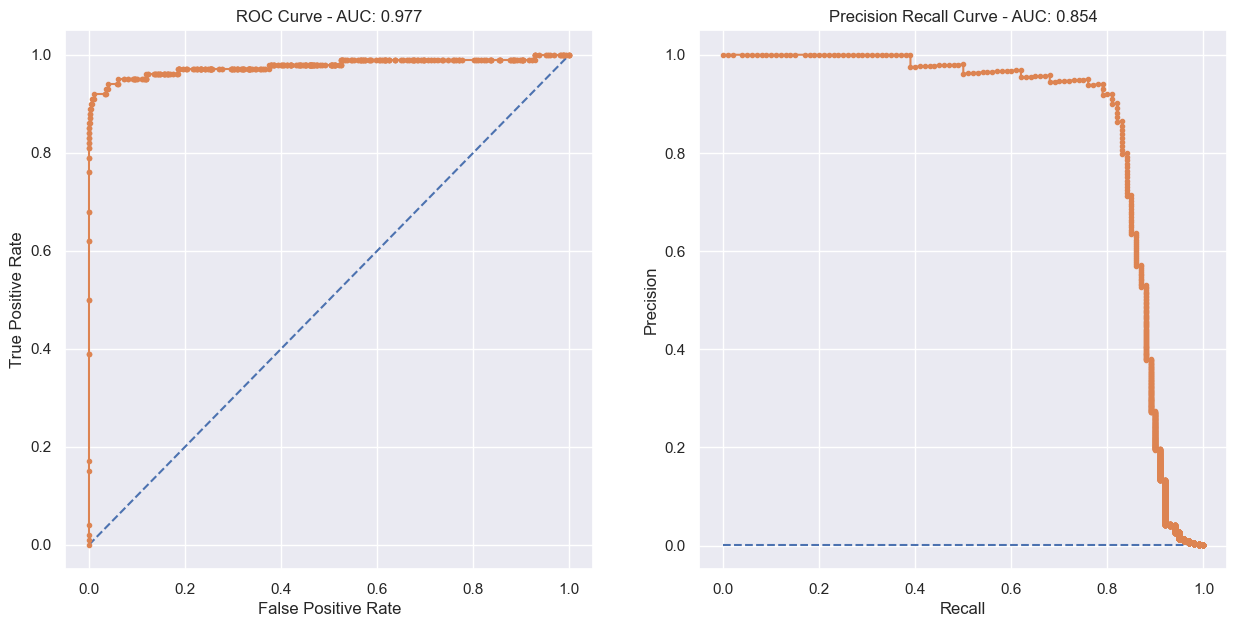

In [67]:
plot_roc(Y_test, Y_hat_proba);

In [68]:
cm, acc, maj, min, f1 = score_model(Y_test, Y_hat)
results_df.loc['Focal Loss'] = [*maj, *min, acc, f1]
results_df

Majority            Minority          Scoring          
                  Precision    Recall Precision Recall  Accuracy        F1
Baseline           0.998244  1.000000       NaN   0.00  0.998244  0.000000
Random             0.999366  0.110847  0.001895   0.96  0.112338  0.003783
Unbalanced         0.999613  0.999912  0.939759   0.78  0.999526  0.852459
Weighted           0.999856  0.979266  0.072384   0.92  0.979162  0.134209
Over Sample        0.999840  0.991506  0.158537   0.91  0.991363  0.270030
Under Sample       0.999838  0.976047  0.062629   0.91  0.975931  0.117193
Balanced Batching  0.999770  0.995814  0.267692   0.87  0.995594  0.409412
Focal Loss         0.999508  0.999930  0.947368   0.72  0.999438  0.818182

<a id='5.9'></a>
## 6.9 Focal Loss + oversample

In [69]:
model = construct_model(loss=focal_loss)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                1984      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [70]:
sampler = RandomOverSampler()
X_over, Y_over = sampler.fit_resample(X_train, Y_train)

In [71]:
history_focal_over_sample = model.fit(
    X_over,
    Y_over,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, Y_val))

Epoch 1/100
1333/1333 [==============================] - 6s 4ms/step - loss: 3.2205 - tp: 157996.0000 - fp: 3598.0000 - tn: 223855.0000 - fn: 12711.0000 - accuracy: 0.9590 - precision: 0.9777 - recall: 0.9255 - auc: 0.9941 - val_loss: 1.1283 - val_tp: 91.0000 - val_fp: 223.0000 - val_tn: 56631.0000 - val_fn: 17.0000 - val_accuracy: 0.9958 - val_precision: 0.2898 - val_recall: 0.8426 - val_auc: 0.9758
Epoch 2/100
1333/1333 [==============================] - 5s 4ms/step - loss: 0.9623 - tp: 166389.0000 - fp: 792.0000 - tn: 169807.0000 - fn: 4210.0000 - accuracy: 0.9853 - precision: 0.9953 - recall: 0.9753 - auc: 0.9995 - val_loss: 0.7418 - val_tp: 90.0000 - val_fp: 186.0000 - val_tn: 56668.0000 - val_fn: 18.0000 - val_accuracy: 0.9964 - val_precision: 0.3261 - val_recall: 0.8333 - val_auc: 0.9725
Epoch 3/100
1333/1333 [==============================] - 5s 4ms/step - loss: 0.5847 - tp: 169277.0000 - fp: 594.0000 - tn: 170005.0000 - fn: 1322.0000 - accuracy: 0.9944 - precision: 0.9965 - re

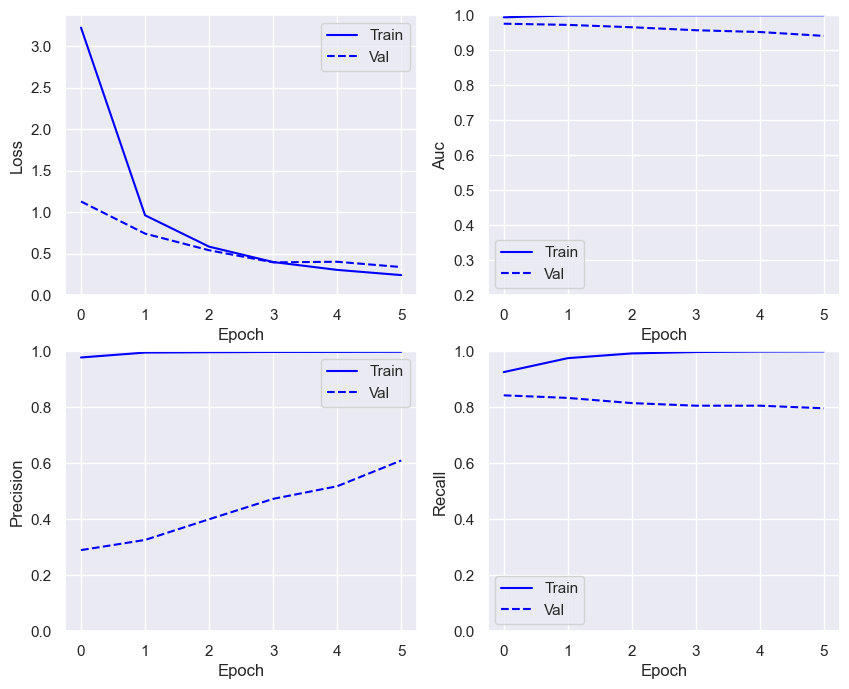

In [72]:
plot_history(history_focal_over_sample)

In [73]:
Y_hat_proba = model.predict(X_test)
Y_hat = np.where(Y_hat_proba > 0.5, 1, 0)
print(classification_report(Y_test, Y_hat))

1781/1781 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.30      0.91      0.45       100

    accuracy                           1.00     56962
   macro avg       0.65      0.95      0.73     56962
weighted avg       1.00      1.00      1.00     56962



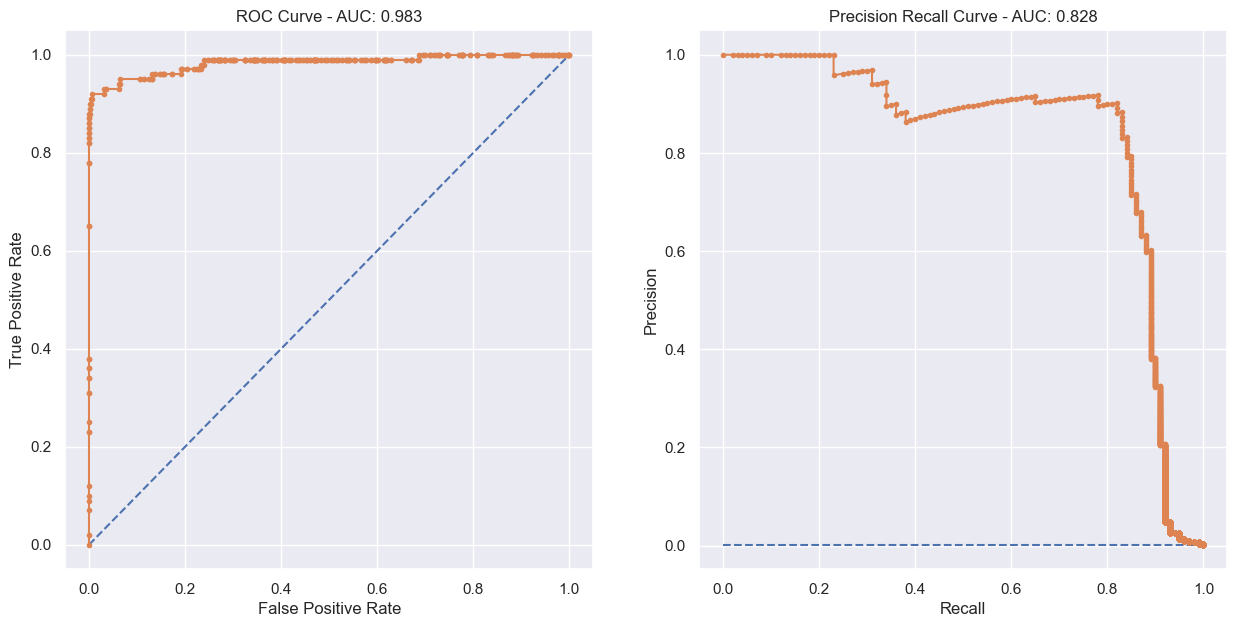

In [74]:
plot_roc(Y_test, Y_hat_proba);

In [75]:
cm, acc, maj, min, f1 = score_model(Y_test, Y_hat)
results_df.loc['Focal Loss + Over Sample'] = [*maj, *min, acc, f1]
results_df

Majority            Minority          Scoring          
                         Precision    Recall Precision Recall  Accuracy        F1
Baseline                  0.998244  1.000000       NaN   0.00  0.998244  0.000000
Random                    0.999366  0.110847  0.001895   0.96  0.112338  0.003783
Unbalanced                0.999613  0.999912  0.939759   0.78  0.999526  0.852459
Weighted                  0.999856  0.979266  0.072384   0.92  0.979162  0.134209
Over Sample               0.999840  0.991506  0.158537   0.91  0.991363  0.270030
Under Sample              0.999838  0.976047  0.062629   0.91  0.975931  0.117193
Balanced Batching         0.999770  0.995814  0.267692   0.87  0.995594  0.409412
Focal Loss                0.999508  0.999930  0.947368   0.72  0.999438  0.818182
Focal Loss + Over Sample  0.999841  0.996307  0.302326   0.91  0.996155  0.453865

<a id='5.10'></a>
## 6.10 Focal Loss + batch balancing

In [76]:
model = construct_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                1984      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [77]:
training_generator = BalancedBatchGenerator(
    X_train, 
    Y_train.to_numpy(), 
    sampler=RandomOverSampler(), 
    batch_size=32, 
    random_state=42)

In [78]:
history_focal_batch_balanced = model.fit(
    training_generator,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    callbacks = [early_stopping])

Epoch 1/100
10662/10662 [==============================] - 34s 3ms/step - loss: 0.0368 - tp: 168733.0000 - fp: 2089.0000 - tn: 225355.0000 - fn: 1969.0000 - accuracy: 0.9898 - precision: 0.9878 - recall: 0.9885 - auc: 0.9993 - val_loss: 0.0179 - val_tp: 89.0000 - val_fp: 240.0000 - val_tn: 56614.0000 - val_fn: 19.0000 - val_accuracy: 0.9955 - val_precision: 0.2705 - val_recall: 0.8241 - val_auc: 0.9501
Epoch 2/100
10662/10662 [==============================] - 34s 3ms/step - loss: 0.0084 - tp: 170543.0000 - fp: 581.0000 - tn: 170009.0000 - fn: 51.0000 - accuracy: 0.9981 - precision: 0.9966 - recall: 0.9997 - auc: 0.9998 - val_loss: 0.0124 - val_tp: 89.0000 - val_fp: 111.0000 - val_tn: 56743.0000 - val_fn: 19.0000 - val_accuracy: 0.9977 - val_precision: 0.4450 - val_recall: 0.8241 - val_auc: 0.9246
Epoch 3/100
10662/10662 [==============================] - 34s 3ms/step - loss: 0.0053 - tp: 170566.0000 - fp: 354.0000 - tn: 170236.0000 - fn: 28.0000 - accuracy: 0.9989 - precision: 0.9979 

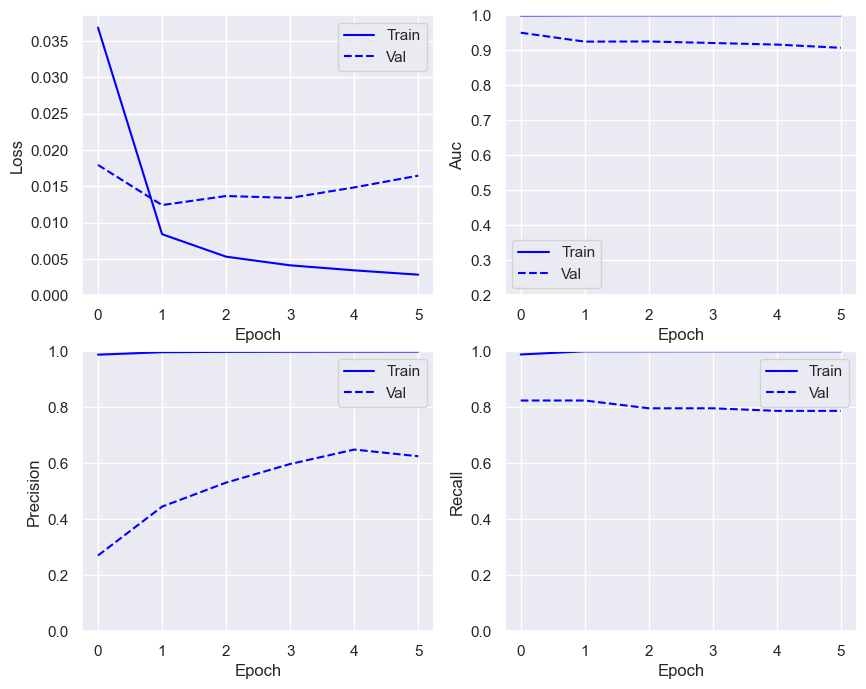

In [79]:
plot_history(history_focal_batch_balanced)

In [80]:
Y_hat_proba = model.predict(X_test)
Y_hat = np.where(Y_hat_proba > 0.5, 1, 0)
print(classification_report(Y_test, Y_hat))

1781/1781 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.26      0.89      0.40       100

    accuracy                           1.00     56962
   macro avg       0.63      0.94      0.70     56962
weighted avg       1.00      1.00      1.00     56962



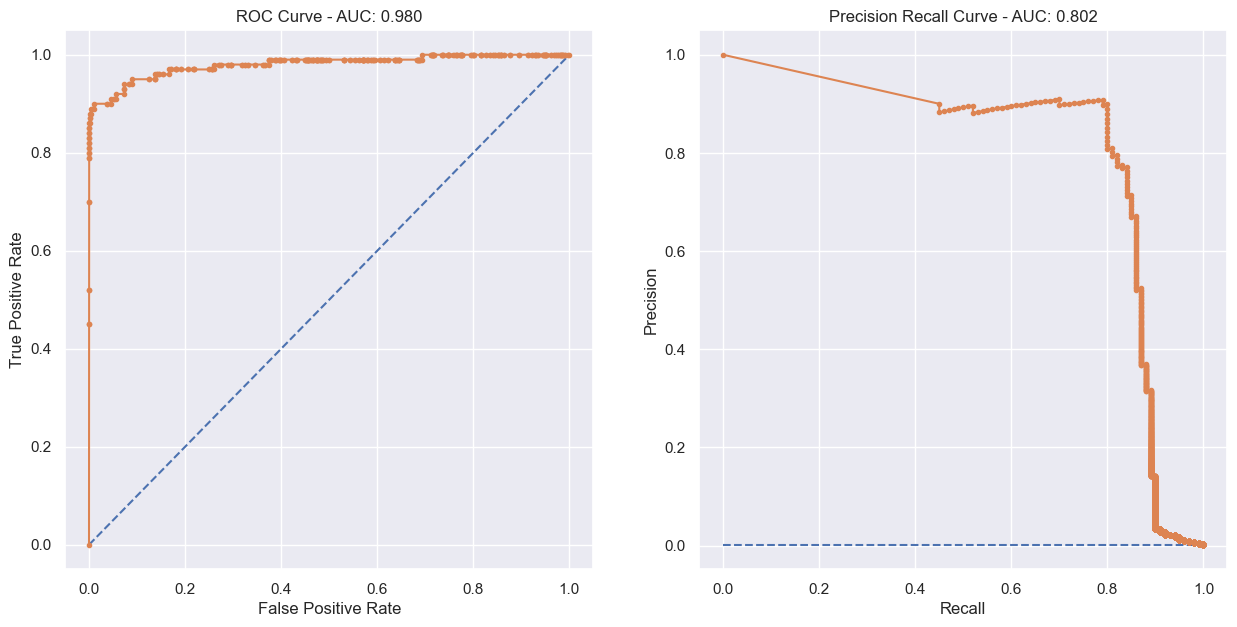

In [81]:
plot_roc(Y_test, Y_hat_proba);

In [82]:
cm, acc, maj, min, f1 = score_model(Y_test, Y_hat)
results_df.loc['Focal Loss + Balanced Batching'] = [*maj, *min, acc, f1]
results_df

Majority            Minority          Scoring          
                               Precision    Recall Precision Recall  Accuracy        F1
Baseline                        0.998244  1.000000       NaN   0.00  0.998244  0.000000
Random                          0.999366  0.110847  0.001895   0.96  0.112338  0.003783
Unbalanced                      0.999613  0.999912  0.939759   0.78  0.999526  0.852459
Weighted                        0.999856  0.979266  0.072384   0.92  0.979162  0.134209
Over Sample                     0.999840  0.991506  0.158537   0.91  0.991363  0.270030
Under Sample                    0.999838  0.976047  0.062629   0.91  0.975931  0.117193
Balanced Batching               0.999770  0.995814  0.267692   0.87  0.995594  0.409412
Focal Loss                      0.999508  0.999930  0.947368   0.72  0.999438  0.818182
Focal Loss + Over Sample        0.999841  0.996307  0.302326   0.91  0.996155  0.453865
Focal Loss + Balanced Batching  0.999806  0.995568  0.260997   0.89  0.995383  0.403628

<a id='6'></a>
# 7. Summary

<a id='6.1'></a>
## 7.1 F1 Score

Highest F1 Score represents a balance between precision and recall

In [83]:
results_df.sort_values(('Scoring', 'F1'), ascending=False)

Majority            Minority          Scoring          
                               Precision    Recall Precision Recall  Accuracy        F1
Unbalanced                      0.999613  0.999912  0.939759   0.78  0.999526  0.852459
Focal Loss                      0.999508  0.999930  0.947368   0.72  0.999438  0.818182
Focal Loss + Over Sample        0.999841  0.996307  0.302326   0.91  0.996155  0.453865
Balanced Batching               0.999770  0.995814  0.267692   0.87  0.995594  0.409412
Focal Loss + Balanced Batching  0.999806  0.995568  0.260997   0.89  0.995383  0.403628
Over Sample                     0.999840  0.991506  0.158537   0.91  0.991363  0.270030
Weighted                        0.999856  0.979266  0.072384   0.92  0.979162  0.134209
Under Sample                    0.999838  0.976047  0.062629   0.91  0.975931  0.117193
Random                          0.999366  0.110847  0.001895   0.96  0.112338  0.003783
Baseline                        0.998244  1.000000       NaN   0.00  0.998244  0.000000

<a id='6.2'></a>
## 7.2 Minority recall

- To get higher recall on the minority class we're sacrificing precision
- If we care more about false positives vs false negatives use a different F-beta score (i.e. F2 or F0.5)

In [84]:
results_df.sort_values(('Minority', 'Recall'), ascending=False)

Majority            Minority          Scoring          
                               Precision    Recall Precision Recall  Accuracy        F1
Random                          0.999366  0.110847  0.001895   0.96  0.112338  0.003783
Weighted                        0.999856  0.979266  0.072384   0.92  0.979162  0.134209
Over Sample                     0.999840  0.991506  0.158537   0.91  0.991363  0.270030
Under Sample                    0.999838  0.976047  0.062629   0.91  0.975931  0.117193
Focal Loss + Over Sample        0.999841  0.996307  0.302326   0.91  0.996155  0.453865
Focal Loss + Balanced Batching  0.999806  0.995568  0.260997   0.89  0.995383  0.403628
Balanced Batching               0.999770  0.995814  0.267692   0.87  0.995594  0.409412
Unbalanced                      0.999613  0.999912  0.939759   0.78  0.999526  0.852459
Focal Loss                      0.999508  0.999930  0.947368   0.72  0.999438  0.818182
Baseline                        0.998244  1.000000       NaN   0.00  0.998244  0.000000